In [1]:
import torch

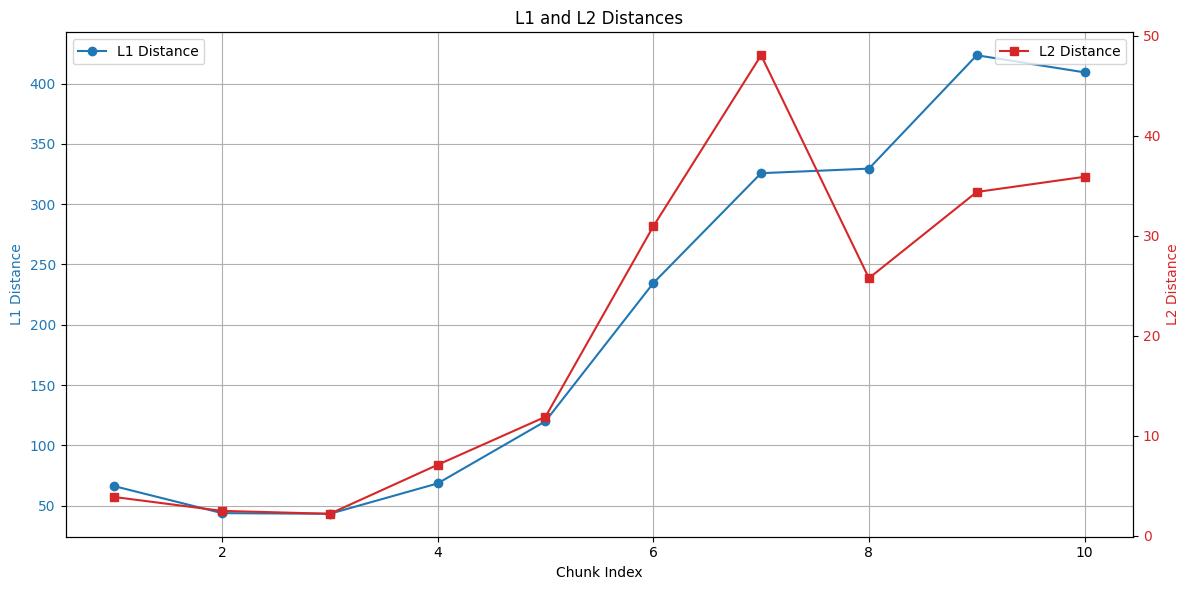

In [3]:
import matplotlib.pyplot as plt
# Assuming L1_distances, L2_distances, and x are already defined
L1_distances = [66.092995, 43.669926, 43.12422, 68.334595, 119.9198, 234.54384, 325.77676, 329.55255, 423.6292, 409.43472]
L2_distances = [3.8712986, 2.4813964, 2.1901631, 7.087502, 11.887709, 30.924534, 48.03465, 25.749748, 34.36614, 35.88483]
x = list(range(1, len(L1_distances) + 1))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot L1 distances on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Chunk Index')
ax1.set_ylabel('L1 Distance', color=color)
ax1.plot(x, L1_distances, 'o-', color=color, label='L1 Distance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.legend(loc="upper left")

# Set up ax2 to be the secondary y-axis with shared x-axis with ax1
ax2 = ax1.twinx()

# Plot L2 distances on the secondary y-axis
color = 'tab:red'
ax2.set_ylabel('L2 Distance', color=color)
ax2.plot(x, L2_distances, 's-', color=color, label='L2 Distance')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right")

# If you have custom x-labels
# custom_labels = ["label1", "label2", "label3", "label4"]  # Replace with your labels
# ax1.set_xticks(x)
# ax1.set_xticklabels(custom_labels)

plt.title('L1 and L2 Distances')
fig.tight_layout()
plt.show()


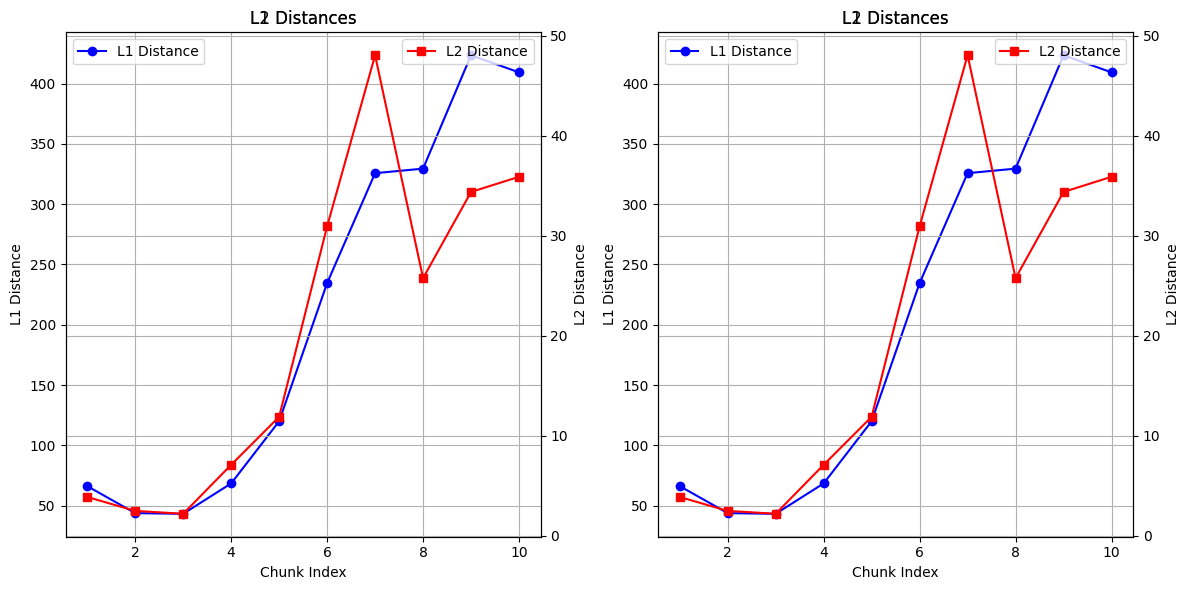

In [19]:
# # Create a figure with two subplots stacked vertically
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Create a figure with two subplots stacked vertically
fig, (ax1,ax3) = plt.subplots(1, 2, figsize=(12, 6))
# Plot L1 distances on the first subplot
ax1.plot(x, L1_distances, 'o-', color='blue', label='L1 Distance')
ax1.set_title('L1 Distances')
ax1.set_xlabel('Chunk Index')
ax1.set_ylabel('L1 Distance')
ax1.legend()
ax1.grid(True)

# Set up ax2 to be the secondary y-axis with shared x-axis with ax1
ax2 = ax1.twinx()
# Plot L2 distances on the second subplot
ax2.plot(x, L2_distances, 's-', color='red', label='L2 Distance')
ax2.set_title('L2 Distances')
ax2.set_xlabel('Chunk Index')
ax2.set_ylabel('L2 Distance')
ax2.legend()
ax2.grid(True)



ax3.plot(x, L1_distances, 'o-', color='blue', label='L1 Distance')
ax3.set_title('L1 Distances')
ax3.set_xlabel('Chunk Index')
ax3.set_ylabel('L1 Distance')
ax3.legend()
ax3.grid(True)


# Set up ax2 to be the secondary y-axis with shared x-axis with ax1
ax4 = ax3.twinx()
# Plot L2 distances on the second subplot
ax4.plot(x, L2_distances, 's-', color='red', label='L2 Distance')
ax4.set_title('L2 Distances')
ax4.set_xlabel('Chunk Index')
ax4.set_ylabel('L2 Distance')
ax4.legend()
ax4.grid(True)


# Adjust layout
fig.tight_layout()
plt.show()

In [ ]:
%%bash
source activate VQTrans

python

# change the text here
clip_text = ["a person is jumping"]



import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/VQTransformer_corruption05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')

## load clip model and datasets
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False, download_root='./')  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)


trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code, 
                                embed_dim=1024, 
                                clip_dim=args.clip_dim, 
                                block_size=args.block_size, 
                                num_layers=9, 
                                n_head=16, 
                                drop_out_rate=args.drop_out_rate, 
                                fc_rate=args.ff_rate)


print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

print ('loading transformer checkpoint from {}'.format(args.resume_trans))
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()

mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model.encode_text(text).float()
index_motion = trans_encoder.sample(feat_clip_text[0:1], False)
pred_pose = net.forward_decoder(index_motion)

from utils.motion_process import recover_from_ric
pred_xyz = recover_from_ric((pred_pose*std+mean).float(), 22)
xyz = pred_xyz.reshape(1, -1, 22, 3)

np.save('motion.npy', xyz.detach().cpu().numpy())

import visualization.plot_3d_global as plot_3d
pose_vis = plot_3d.draw_to_batch(xyz.detach().cpu().numpy(),clip_text, ['example.gif'])

### VQVEA- KIT

In [4]:
ckpt_kit = torch.load('../pretrained/VQVAE_KIT/net_best_fid.pth', map_location ='cpu')
codebook_kit = ckpt_kit['net']['vqvae.quantizer.codebook']

In [13]:
ck = codebook_kit.numpy()

In [44]:
codebook_kit

tensor([[ 1.2788,  0.7047, -0.0526,  ..., -0.1578,  2.3753,  1.1482],
        [ 0.1483,  4.3592,  3.0455,  ...,  0.5980, -5.8417, -2.4059],
        [-2.1413, -0.3750, -2.9218,  ..., -0.0105, -2.6452,  0.6532],
        ...,
        [ 0.1417,  2.2339, -1.8164,  ..., -2.9157,  2.0044, -0.6128],
        [ 1.4058,  1.8730,  3.2300,  ...,  1.0657, -1.4700,  0.5515],
        [-0.3201, -0.7897, -3.0091,  ..., -1.2063, -2.0032,  1.1831]])

In [8]:
codebook_kit.shape

torch.Size([512, 512])

### DBSCAN

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

In [60]:
ck

array([[ 1.2787648 ,  0.7047256 , -0.05260776, ..., -0.15778588,
         2.3753247 ,  1.148212  ],
       [ 0.14830594,  4.3591647 ,  3.0454836 , ...,  0.5979667 ,
        -5.841696  , -2.4059432 ],
       [-2.141325  , -0.3749858 , -2.9218402 , ..., -0.01047894,
        -2.6451638 ,  0.6532162 ],
       ...,
       [ 0.14173298,  2.2339208 , -1.8163776 , ..., -2.9157283 ,
         2.004351  , -0.6127765 ],
       [ 1.4057771 ,  1.872981  ,  3.2300375 , ...,  1.0657195 ,
        -1.4700342 ,  0.5515491 ],
       [-0.32008162, -0.78968984, -3.009075  , ..., -1.2063437 ,
        -2.0031643 ,  1.1831416 ]], dtype=float32)

In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(ck)


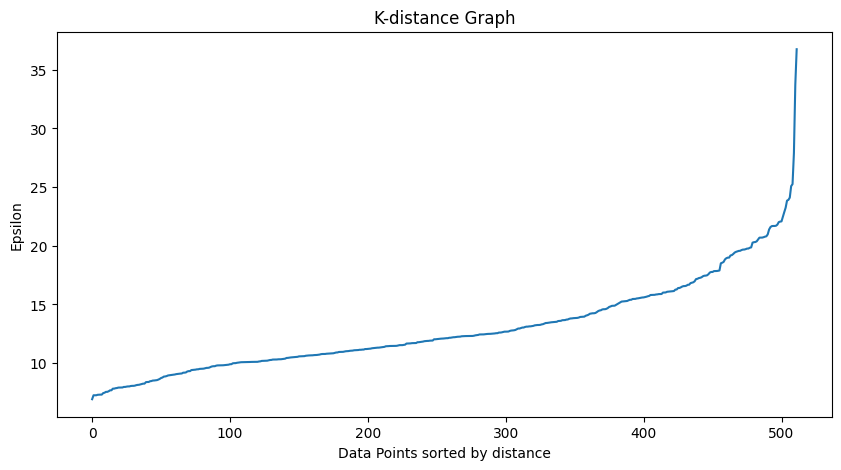

In [101]:
# Find the nearest neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=4)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Sort distance values
distances = np.sort(distances[:,3], axis=0)

# Plot
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

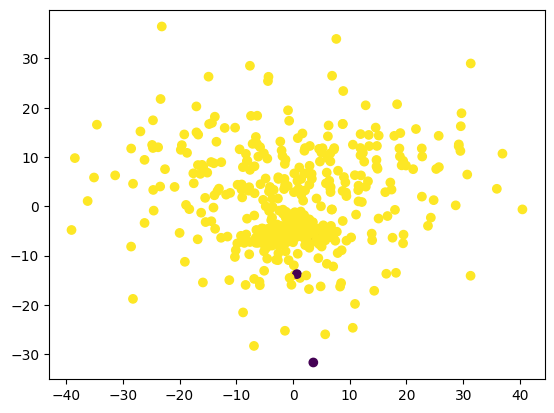

In [108]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering using chosen eps and min_samples values
dbscan = DBSCAN(eps=23, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.show()

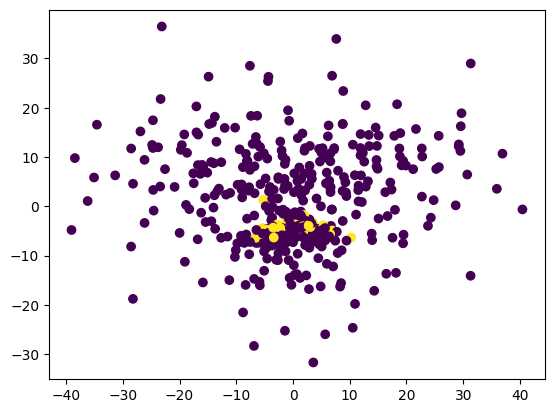

In [80]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.show()


In [56]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [92]:
labels = np.arange(512)

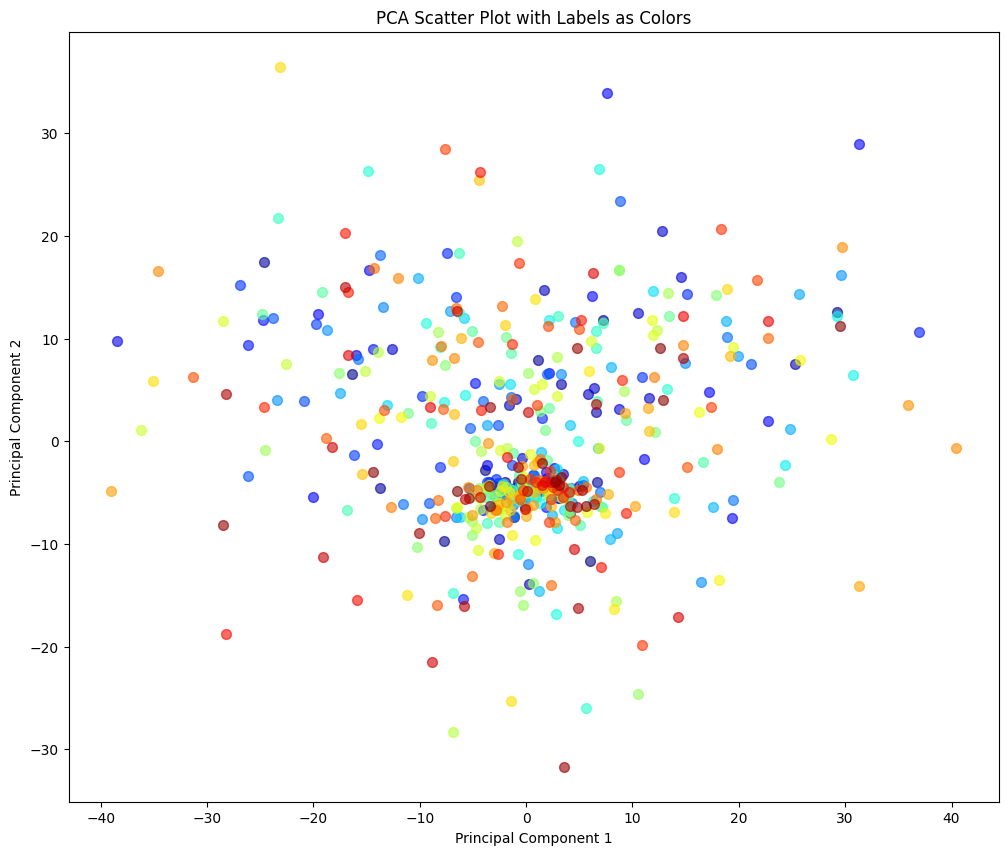

In [93]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.jet(np.linspace(0, 1, 512))  # Create a color map with 512 distinct colors

plt.figure(figsize=(12, 10))

for i, color in enumerate(colors):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], c=[color], label=i, s=50, alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Labels as Colors')

# Uncomment the line below if you want to show a legend, but with 512 labels it might be overwhelming
# plt.legend(loc='best')

plt.show()


In [ ]:
dbscan = DBSCAN(eps=23, min_samples=3).fit(X_scaled)
labels = dbscan.labels_

In [109]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [110]:
# Generate sample
centers = [[1, 1], [-1, -1], [1, -1]]
X, y = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

In [111]:
y

array([0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 2, 2, 1, 1, 1,
       1, 1, 0, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2,
       1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2,
       2, 2, 0, 1, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1, 1, 2,
       2, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 1,
       1, 2, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1,
       1, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 1, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1,
       2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1,
       1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2,
       2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0,